# UFO

<font color='#660066'>
   
### Table of Contents

- [Data](#Data)
    - [Scraping from UFORC](#Scraping-from-UFORC)
    - [Data Format](#data_format)
    - [Cleaing Data](#cleaning_pdata)
- [Basic anlayis](#Basic-Anylsis)
- [Milestone 3](#milestones)

In [1]:
%load_ext autoreload
%autoreload 2
import json
import pandas as pd
from matplotlib.pyplot import *
from lib.scraping import fetch_shape_urls,  \
                     fetch_all_sighting_urls, \
                     store_to_json, \
                     build_report_dataframe
from lib.postprocessing import get_time_of_occurrence, \
                           to_datetime_add_year, \
                           replace_empty_with_nan, \
                           distribution_histogram 
from lib.cleaning import clean_data, \
                        clean_duration_get_min
from lib.nuforc_analysis import *
from wordcloud import WordCloud

In [2]:
data_folder = "data/"

file_url_list = data_folder+'full_list_of_urls.json'

report_file = 'for_jurgis.csv'

<font color='#660066'>
    
## Loading data

of course we dont want so scrape every time

In [3]:
df_reports = pd.read_csv(data_folder+report_file)
df_reports.sample(1).head()

,Unnamed: 0,Duration,Location,Occurred,Posted,Reported,Shape,Summary,url
59214,47410,1 minute,"Savannah, GA",8/5/2015 21:45 (Entered as : 08/05/15 21:45),8/6/2015,8/6/2015 5:46:34 AM 05:46,Formation,5 White Lights hoveringI was driving down Bay ...,http://www.nuforc.org/webreports/120/S120918.html


In [4]:
df_reports.shape

(117644, 9)

<font color='#660066'>

## Data cleaning

With the clean data function we are removing the 'bad' durations, reforming the 'Occured' and 'Reported', splitting the 'Summary' tab into 'NUFORC' comments and the general statement. Splitting the MADAR reports from he main reports and setting the unique index to URL

In [5]:
df_reports, df_madarr = clean_data(df_reports)

KeyError: '[111938  97125  92361  87440 110228  45333  80653  58194  55810  54939\n 110807  54694  30841  57254] not found in axis'

In [6]:
df_reports.shape

(117193, 10)

In [8]:
df_reports.sample(1).head()

,Duration,Location,State,Occurred,Posted,Reported,Shape,Summary,nuforc_note,link
url,,,,,,,,,,
http://www.nuforc.org/webreports/055/S55420.html,5.0,Milwaukee,WI,2007-02-17 06:30:00,2/24/2007,2007-02-23 18:45:00,Oval,['Did any one report seeing a UFO around 6:30 ...,[],[]


<font color='#660066'>

## Occurance analyis and peak detection

We are searching for peaks in the data to see if there are some seasonal data correlation and if we can relate specific weather events (storms, tornados, earthquakes) to peaks which pop out of the main distribution of occurances.

In [12]:
df_peaks = df_reports[['Occurred']].copy()
df_peaks = df_peaks[(df_peaks.Occurred.dt.year > 1900)]
index_list = df_peaks[df_peaks.Occurred.isna()].index
df_peaks = df_peaks.dropna()
df_peaks['year_month'] = df_peaks.Occurred.map(lambda x: x.strftime('%m'))
plotting_times = df_peaks.groupby(by='year_month').count()

Text(0,0.5,'Amount')

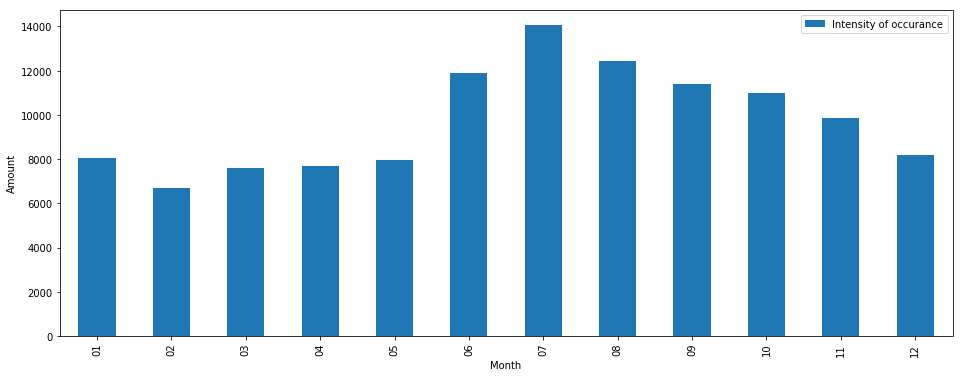

In [13]:
fig, ax = subplots()
plotting_times.plot.bar(figsize=(16,6), ax=ax)
ax.legend(['Intensity of occurance'])
xlabel("Month")
ylabel('Amount')

<font color='#660066'>


### Analysis
This plot shows the amount of reported occurances per month from 1900-2018.
We can see a very clear trend that during the summer months when there is an increase in submitted reports.
This can be reasoned with very logicaly, because during warmer periods people tend to spend more time outside, thus have a higher probability of making a sighting of a UFO.

But we see a clear increase in July, thus we will be investigating this month more, by plotting the reports from July over the time frame 1900 to 2018.

In [14]:
df_july = df_reports[['Occurred']].copy()
df_july = df_july[(df_july.Occurred.dt.year > 1900)]
df_july = df_july[(df_july.Occurred.dt.month == 7)]
index_list = df_july[df_july.Occurred.isna()].index
df_july = df_july.dropna()
df_july['days'] = df_july.Occurred.map(lambda x: x.strftime('%d'))
july_plotting_times = df_july.groupby(by='days').count()

Text(0,0.5,'Amount')

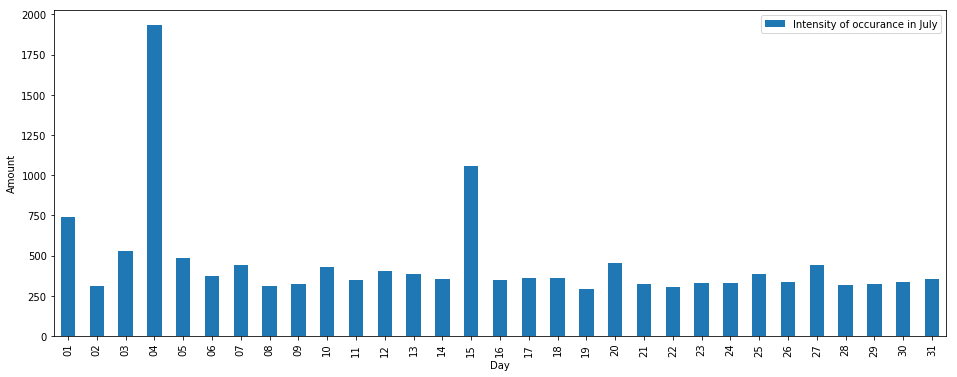

In [15]:
fig, ax = subplots()
july_plotting_times.plot.bar(figsize=(16,6), ax=ax)
ax.legend(['Intensity of occurance in July'])
xlabel("Day")
ylabel('Amount')

<font color='#660066'>


## Analysis
Now, here things start to become very interesting. We can quite obviously see an increase for the 4th of July, as a lot of sightings might be connected with the fireworks in the US. 

Though, another very clear increase is on the 15th of July, but after a google query, no specific occurance in the month of July was found. Thus, an investigation of the 15th of July over the years occurs. What is more interesting, is that the increase on the 15th day of the month can be seen across multiple months.

In [16]:
def get_data_for_months(df):
    df_month = df[['Occurred']].copy()
    df_month = df_month[(df_month.Occurred.dt.year > 1900)]
    months = []
    for i in range(1,13):
        df_month_iter = df_month[(df_month.Occurred.dt.month == i)].copy()
        index_list = df_month_iter[df_month_iter.Occurred.isna()].index
        df_month_iter = df_month_iter.dropna()
        df_month_iter['days'] = df_month_iter.Occurred.map(lambda x: x.strftime('%d'))
        each_month = df_month_iter.groupby(by='days').count()
        months.append(each_month)
    return months

In [17]:
months = get_data_for_months(df_reports)

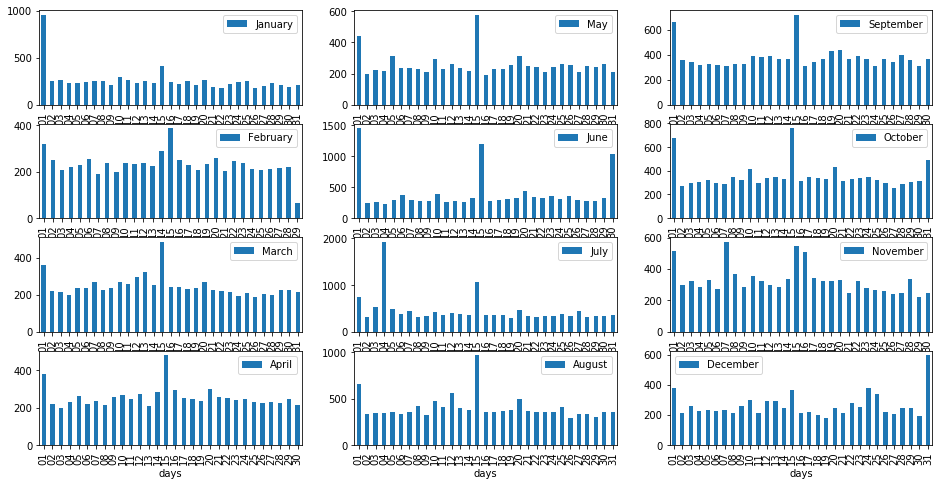

In [18]:
figs, axis = subplots(nrows=4,ncols=3)
months[0].plot.bar(ax=axis[0,0],figsize=(16,8))
axis[0,0].legend(['January'])
months[1].plot.bar(ax=axis[1,0])
axis[1,0].legend(['February'])
months[2].plot.bar(ax=axis[2,0])
axis[2,0].legend(['March'])
months[3].plot.bar(ax=axis[3,0])
axis[3,0].legend(['April'])
months[4].plot.bar(ax=axis[0,1])
axis[0,1].legend(['May'])
months[5].plot.bar(ax=axis[1,1])
axis[1,1].legend(['June'])
months[6].plot.bar(ax=axis[2,1])
axis[2,1].legend(['July'])
months[7].plot.bar(ax=axis[3,1])
axis[3,1].legend(['August'])
months[8].plot.bar(ax=axis[0,2])
axis[0,2].legend(['September'])
months[9].plot.bar(ax=axis[1,2])
axis[1,2].legend(['October'])
months[10].plot.bar(ax=axis[2,2])
axis[2,2].legend(['November'])
months[11].plot.bar(ax=axis[3,2])
axis[3,2].legend(['December'])

<font color='#660066'>

We can see a very clear trend across all months, that during the 15th day of the month there is a sudden increase in occured reportings of UFOs. Also, in most months there is a peak on the first day of the month. And in some months there are also other peaks, which most of the time can be explained due to holidays and such events.

Now to look into the 15th of July specifically over the years.

In [19]:
df_15july = df_reports[['Occurred']].copy()
df_15july = df_15july[(df_15july.Occurred.dt.year > 1900)]
df_15july = df_15july[(df_15july.Occurred.dt.month == 7)]
df_15july = df_15july[(df_15july.Occurred.dt.day== 15)]
index_list = df_15july[df_15july.Occurred.isna()].index
df_15july = df_15july.dropna()
df_15july['years'] = df_15july.Occurred.map(lambda x: x.strftime('%Y'))
july15_plotting_times = df_15july.groupby(by='years').count()

Text(0,0.5,'Amount')

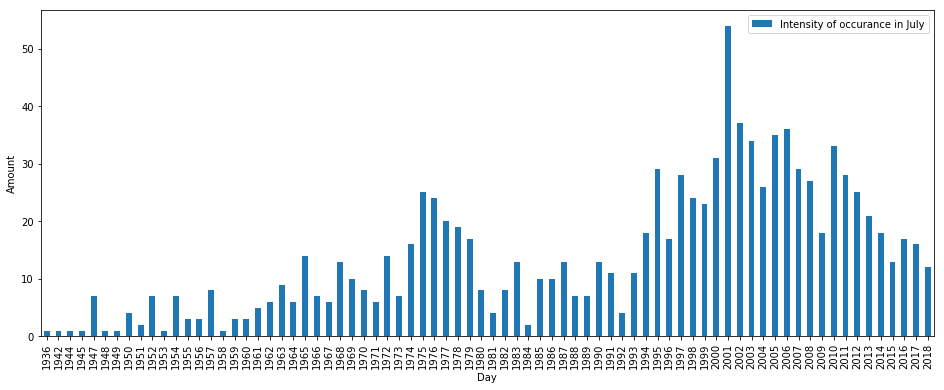

In [20]:
fig, ax = subplots()
july15_plotting_times.plot.bar(figsize=(16,6), ax=ax)
ax.legend(['Intensity of occurance in July'])
xlabel("Day")
ylabel('Amount')

<font color='#660066'>

We see no particaular increase on the 15th of July over the years, so there might be some other reason for this phenomena.

<font color='#660066'>

Thus, we're going to do some more indepth analysis on these reports - text analysis, time of report, duration.

In [21]:
df_15th = df_reports[['Occurred']].copy()
df_15th = df_15th[(df_15th.Occurred.dt.year > 1900)]
df_15th = df_15th[(df_15th.Occurred.dt.day == 15)]
index_list = df_15july[df_15th.Occurred.isna()].index
df_15th = df_15th.dropna()
df_15th['15th over years'] = df_15th.Occurred.map(lambda x: x.strftime('%Y'))
plotting_15th_day = df_15th.groupby(by='15th over years').count()

C:\Users\jurgi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


Text(0,0.5,'Amount')

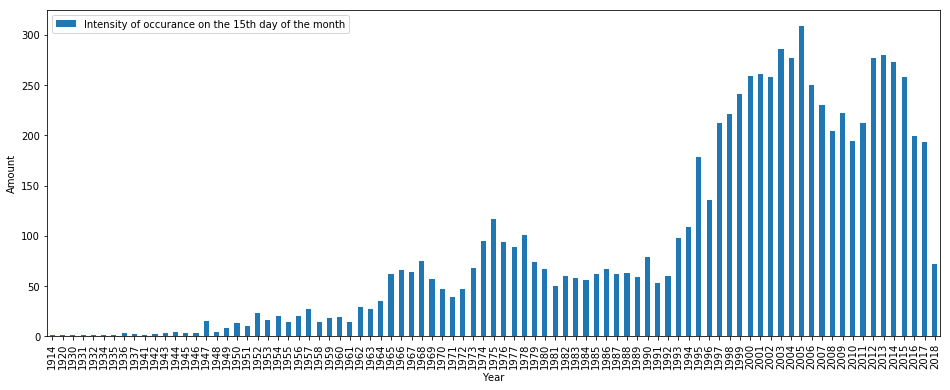

In [22]:
fig, ax = subplots()
plotting_15th_day.plot.bar(figsize=(16,6), ax=ax)
ax.legend(['Intensity of occurance on the 15th day of the month'])
xlabel("Year")
ylabel('Amount')

<font color='#660066'>

And again, nothing specific can be noticed for the 15th day of the month.

Thus, exctracting the reports of the 15th day of the month.

In [9]:
df_15th_full = df_reports.copy()
df_15th_full = df_15th_full[(df_15th_full.Occurred.dt.year > 1900)]
df_15th_full = df_15th_full[(df_15th_full.Occurred.dt.day == 15)]
df_15th_full.shape

(7954, 10)

In [26]:
summaries_15th = df_15th_full['Summary'].values
all_summaries = df_reports['Summary'].values

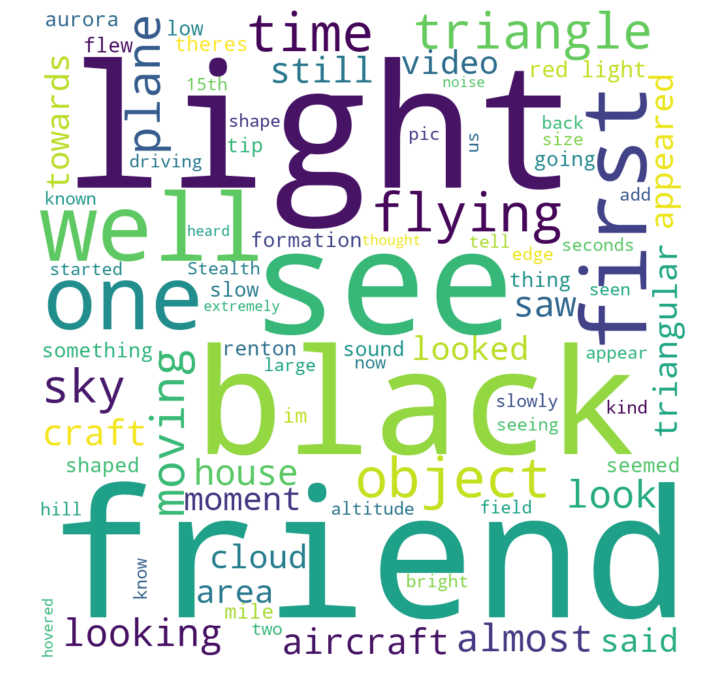

In [25]:
text_15th = str(summaries_15th)
x, y = np.ogrid[:1000, :1000]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc = WordCloud(background_color="white", repeat=False, width=1000, height=1000, max_words=80)
wc.generate(text_15th)
plt.figure(figsize=(12, 12))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

<font color='#660066'>

We noticed a very interesting occurance on the 15th day of the month from 1900. By making a wordcloud plot we could see that the word 'friend' appears. After going through all of the other days we noticed that the name 'friend' doens't appear in any other month nearly as much, so to get the comparision and see if the 15th is an outlier. And then we decided to actually check wether the WordCloud library gives us the correct output. We're going to check that by runnning the reports through the NLTK tokenizer and then making a word frequency list.

In [26]:
df_days_full = df_reports.copy()
df_days_full = df_days_full[(df_days_full.Occurred.dt.year > 1900)]
#df_days_full = df_1th_full[(df_1th_full.Occurred.dt.day == 31)]
df_days_full.shape

(116838, 10)

In [1]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jurgi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
wordToFrequency = {}
for item in summaries_15th:
    tokens = tokenizer.tokenize(item)
    for t in tokens:
        if t.lower() not in stopwords.words('english'):
            #print(t.lower())
            if t in wordToFrequency:
                wordToFrequency.update({t: wordToFrequency[t] + 1})
            else:
                wordToFrequency[t] = 0
# From collections use counter, concat all of the summaries and feed it to counter

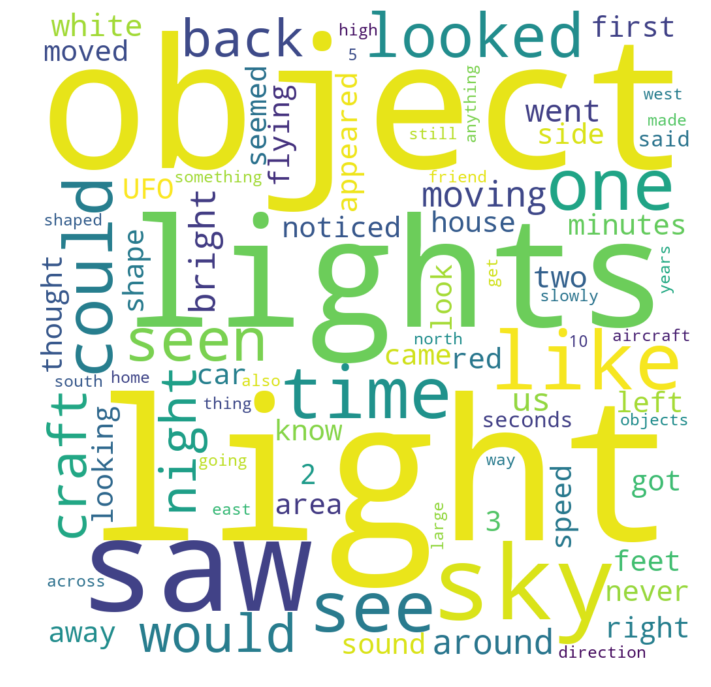

In [23]:
df_15th = pd.DataFrame.from_dict(wordToFrequency, orient='index')
#abc.sort_values(0, ascending=False).head(100)
wc = WordCloud(background_color="white", repeat=False, width=1000, height=1000, max_words=80)
wc.fit_words(wordToFrequency)
plt.figure(figsize=(12, 12))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

<font color='#660066'>

Well, what about that, the wordcloud library doesn't work well with pandas it seems, because the output is completely different across the NLTK frequency wordcloud and the inbuilt generator for wordcloud. The problem seems to appear, because the notebook doesn't output the whole text when converting to string and thus the wordcloud generator cannot output the correct result. 

In [ ]:
wordToFrequency_all = {}
for item in all_summaries:
    tokens = tokenizer.tokenize(item)
    for t in tokens:
        if t.lower() not in stopwords.words('english'):
            #print(t.lower())
            if t in wordToFrequency_all:
                wordToFrequency_all.update({t: wordToFrequency_all[t] + 1})
            else:
                wordToFrequency_all[t] = 0

In [ ]:
df_all = pd.DataFrame.from_dict(wordToFrequency_all, orient='index')
#abc.sort_values(0, ascending=False).head(100)
wc = WordCloud(background_color="white", repeat=False, width=1000, height=1000, max_words=80)
wc.fit_words(wordToFrequency_all)
plt.figure(figsize=(12, 12))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

<font color='#660066'>

## Duration analysis

We are also looking at the analysis of durations, the distribution and what they imply.

In [28]:
df_durations = df_reports[['Duration', 'Occurred', 'Shape']].copy()

In [8]:
df_durations.sample(1).head()

,Duration,Occurred,Shape
url,,,
http://www.nuforc.org/webreports/005/S05524.html,0.033333,1999-01-14 22:20:00,Fireball


Text(0.5,1,'Distribution of report durations')

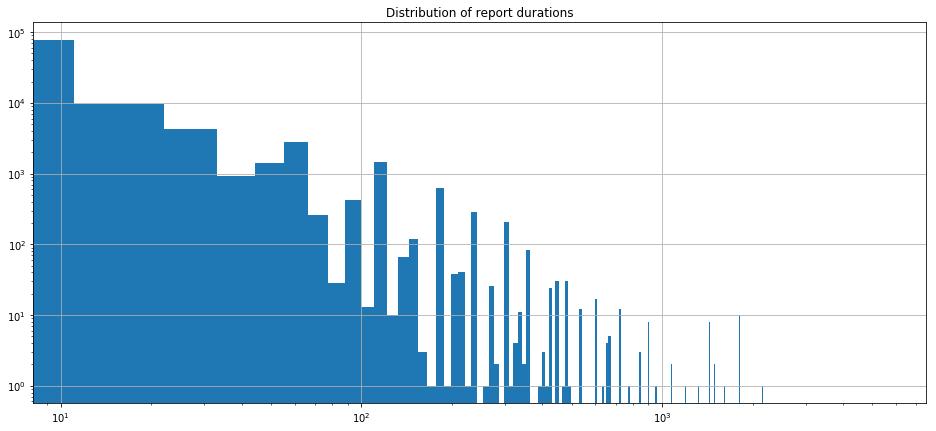

In [27]:
fig, ax = subplots()

df_durations.Duration.hist(ax=ax, bins = 500, figsize=(16,7))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('Distribution of report durations')

<font color='#660066'>
    
## Analysis

We can see that the duration tab follows a power law distribution, which makes sense as most durations would be for a small time frame (like falling meteorites, light flashes, etc). And some of the very long ones could be explained also by the description not matching up to the duration. That is, some people write a very long durration, but it actually means that the occurance happens for short periods over a longer time scale.

<font color='#660066'>
    
We plan on putting this data on the map for a semi-interactive map of durations and whatnot.
We are also going to look into the duration correlation with the report occurance over time, etc.

In [31]:
output = 'sentiment.csv'
df_sentiment = pd.read_csv(output)
df_sentiment.Filename = df_sentiment.Filename.str.replace('-', '/', regex=False)
df_sentiment.Filename = df_sentiment.Filename.str.replace('.txt', '', regex=False)
df_reports = df_reports.merge(df_sentiment, left_on='url', right_on='Filename', how='left')

In [32]:
df_reports

,Duration,Location,State,Occurred,Posted,Reported,Shape,Summary,nuforc_note,link,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,10.000000,Lutz,FL,2018-10-30 23:30:00,11/9/2018,2018-10-30 20:54:00,,['Blinking white light that moved every few se...,[((NUFORC Note: We have attempted to contact ...,[],...,1.54,3.08,0.00,0.0,0.0,0.00,0.00,0.0,12.31,0.00
1,4.500000,Bridgewater,NJ,2011-11-23 00:45:00,6/5/2012,2012-06-05 12:37:00,,['EXPLAINED: Bright lights in Somerset county ...,[((NUFORC Note: Witness elects to remain tota...,[http://www.nj.com/news/index.ssf/2011/11/brig...,...,2.44,1.22,0.61,0.0,0.0,0.61,1.22,0.0,3.66,8.54
2,2.000000,South Fork,CO,2001-10-04 14:00:00,3/21/2003,2001-10-15 13:27:00,Cigar,"['Shinny Cigar shape in sky on clear day.', 'D...",[],[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10.000000,Hattiesburg,MS,2014-12-17 20:00:00,8/13/2015,2015-08-09 21:11:00,Triangle,['I saw a triangular UFO with red and white li...,[],[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.125000,LaBelle,FL,2014-12-17 17:19:00,12/18/2014,2014-12-17 18:21:00,Triangle,"['White Triangle in South Florida', 'My co-wor...",[],[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.500000,Maryland Heights,MO,2014-12-16 17:15:00,12/18/2014,2014-12-16 21:33:00,Triangle,['I was driving on my motorcycle on hwy 141 at...,[],[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,Fort Mill,SC,2014-12-16 17:00:00,12/18/2014,2014-12-16 19:01:00,Triangle,['Triangular craft with lights are corners wit...,[((NUFORC Note: Witness elects to remain tota...,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,5.000000,Lenoir City,TN,2014-12-15 05:30:00,1/7/2015,2014-12-28 18:11:00,Triangle,['My wife and I were on our way to work. She s...,[],[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,30.000000,Augusta,GA,2014-12-14 22:00:00,12/18/2014,2014-12-14 19:16:00,Triangle,"[""I was coming home from work when I noticed 3...",[],[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10.000000,Meriden,CT,2014-12-14 09:50:00,12/18/2014,2014-12-14 19:30:00,Triangle,['1 Very Large triangle shaped 5 lights around...,[],[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<font color='#660066'>
    
## Scrapping Air-base, rocket launch locations
Done

<font color='#660066'>

# Getting some weather data in this place

In [140]:
!ls data/weather/

StormEvents_details-ftp_v1.0_d1950_c20170120.csv.gz
StormEvents_locations-ftp_v1.0_d1996_c20170717.csv.gz


In [129]:
storm_folder = 'data/weather/'

In [143]:
storms = pd.read_csv(storm_folder+'StormEvents_details-ftp_v1.0_d1950_c20170120.csv.gz')
#storms = pd.read_csv(storm_folder+'StormEvents_locations-ftp_v1.0_d1996_c20170717.csv.gz')

In [145]:
storms.shape

(223, 51)

In [6]:
def clean_duration_get_min(df):
    """
    Cleans the duration section by dropping all values, which are more than a week
    Cleans the time formats and converts all of the to 'min'
    By cleaning the data we are left with 86% of the intial data,
    Which is reasonable for us, as initially there were about 10000 different
    Time formats
    Returns:
        --cleaned series with updated durations in min
    """
    df_dummy = df.Duration.copy()
    df_dummy = df_dummy.to_frame()
    df_dummy.Duration = df_dummy.Duration.str.lower()
    df_dummy = df_dummy.dropna()
    df_dummy['time_format'] = df_dummy.Duration
    hr_time = df_dummy.copy()
    hr_time.Duration = hr_time.Duration[hr_time.Duration.str.contains('1 hr')]
    hr_time = hr_time.dropna()
    hr_time.Duration = 60
    hr_time.time_format = 'min'
    hrs_time = df_dummy.copy()
    hrs_time.Duration = hrs_time.Duration[hrs_time.Duration.str.contains('hrs')]
    hrs_time = hrs_time.dropna()
    hrs_time.Duration = hrs_time.Duration.str.replace('[:-]', '.')
    hrs_time.Duration = hrs_time.Duration.str.replace(' 1/2', '.5')
    hrs_time.Duration = hrs_time.Duration.str.replace('/', '.')
    repl = lambda m: m.group('one')
    hrs_time.Duration = hrs_time.Duration.str.replace(r"(?P<one>.*)hrs.*", repl, regex=True)
    hrs_time.Duration = hrs_time.Duration.str.replace(r"[^0-9]*(?P<one>[0-9][0-9 \.]*)[\w\. ]*", repl, regex=True)
    hrs_time.Duration = hrs_time.Duration.str.replace('[+a-z ]', '')
    hrs_time.time_format = 'hour'
    manual_drop_hrs = [111938, 97125, 92361, 87440, 110228, 45333, 80653, 58194, 55810, 54939, 110807, 54694, 30841, 57254]
    hrs_time = hrs_time.drop(manual_drop_hrs)
    hrs_time.Duration = hrs_time.Duration[~(hrs_time.Duration == '')]
    hrs_time = hrs_time.dropna()
    hrs_time.Duration = hrs_time.Duration.astype(float)
    hrs_time.Duration = hrs_time.Duration*60
    hrs_time.time_format = 'min'
    hour_time = df_dummy.copy()
    hour_time.Duration = hour_time.Duration[hour_time.Duration.str.contains('hour')]
    hour_time = hour_time.dropna()
    hour_time.Duration = hour_time.Duration.str.replace('[:-]', '.')
    hour_time.Duration = hour_time.Duration.str.replace(' 1/2', '.5')
    hour_time.Duration = hour_time.Duration.str.replace('/', '.')
    hour_time.Duration = hour_time.Duration.str.replace(r"(?P<one>.*)hour.*", repl, regex=True)
    hour_time.Duration = hour_time.Duration.str.replace(r"[^0-9]*(?P<one>[0-9][0-9 \.]*)[\w\. ]*", repl, regex=True)
    hour_time.Duration = hour_time.Duration.str.replace('[+a-z ?\(\)&"`,!>;]', '')
    hour_time.Duration = hour_time.Duration.str.replace('([.]{2,})', '')
    manual_drop_hours = [109182, 102324, 96844, 93487, 93353, 80915, 88291, 78633, 63452, 66319, 67243, 44816, 22126, 30095, 68130, 91121, 80095, 71731, 61714, 38278, 24674, 107114, 111918]
    hour_time = hour_time.drop(manual_drop_hours)
    hour_time.Duration = hour_time.Duration.str.replace('\.$', '')
    hour_time.time_format = 'hour'
    hour_time.Duration = hour_time.Duration[~(hour_time.Duration == '')]
    hour_time = hour_time.dropna()
    hour_time.Duration = hour_time.Duration.astype(float)
    hour_time.Duration = hour_time.Duration*60
    hour_time.time_format = 'min'
    minutes_time = df_dummy.copy()
    minutes_time.Duration = minutes_time.Duration.dropna()[minutes_time.Duration.dropna().str.contains('min')]
    minutes_time.time_format = 'min'
    minutes_time = minutes_time.dropna()
    minutes_time.Duration = minutes_time.Duration.str.replace(' 1/2', '.5')
    minutes_time.Duration = minutes_time.Duration.str.replace('to', '-')
    minutes_time.Duration = minutes_time.Duration.str.replace('or', '-')
    minutes_time.Duration = minutes_time.Duration.str.replace('[/:]', '.')
    minutes_time['Duration'] = minutes_time.Duration.str.replace(r"(?P<one>.*)hour.*", repl, regex=True)
    minutes_time['Duration'] = minutes_time.Duration.str.replace(r"[^0-9]*(?P<one>[0-9][0-9 -\.]*)[\w\. ]*", repl, regex=True)
    minutes_time['Duration'] = minutes_time.Duration.str.replace('[+a-z ?±*\(\)½!<>\\\\=~&"á`,\'!>;\[\]@]', '')
    minutes_time['Duration'] = minutes_time.Duration.str.replace('([.]{2,})', '')
    minutes_time['Duration'] = minutes_time.Duration.str.replace('([-]{2,})', '')
    minutes_manual_drop = [2708, 7632, 17491, 26323, 17743, 19051, 21642, 25011, 27849, 28293, 35538, 39992, 75636, 78172, 82754, 93849, 95787, 4126, 24350, 95915, 102106, 4627, 85033, 85683, 14141, 16443, 69234, 77029, 101165, 42895, 19145, 56129, 75795, 115300, 113583, 112874, 105620, 88135, 87478, 75795, 60077, 55454, 78279, 113942, 43457, 4597, 6962, 9217, 19169,  32546, 41128, 61391, 63575, 82235, 101547, 32357, 89937]
    minutes_time = minutes_time.drop(minutes_manual_drop)
    minutes_time['Duration'] = minutes_time.Duration.str.replace('\-$', '')
    minutes_time.Duration = minutes_time.Duration.str.replace('\.$', '')
    minutes_time.Duration = minutes_time.Duration.str.replace('\.-$', '')
    minutes_time.Duration = minutes_time.Duration[~(minutes_time.Duration == '')]
    minutes_time = minutes_time.dropna()
    extended_duration = minutes_time[minutes_time.Duration.str.contains('-')]
    seperated_duration = extended_duration.Duration.str.split('-')
    seperated_duration = seperated_duration[~(seperated_duration.str[0] == '')]
    seperated_duration = seperated_duration[~(seperated_duration.str[1] == '')]
    calculated_averages_of_durations = (seperated_duration.str[0].astype(float)+seperated_duration.str[1].astype(float))/2
    minutes_time.update(calculated_averages_of_durations)
    minutes_time.Duration = minutes_time.Duration.astype(str).str.replace('[-]', '')
    minutes_time.Duration = minutes_time.Duration[~(minutes_time.Duration == '')]
    minutes_time = minutes_time.dropna()
    minutes_time.Duration = minutes_time.Duration.astype(float)

    sec_time = df_dummy.copy()
    sec_time.Duration = sec_time.Duration.dropna()[sec_time.Duration.dropna().str.contains('sec')]
    sec_time.time_format = 'sec'
    sec_time = sec_time.dropna()
    sec_time.Duration = sec_time.Duration.str.replace(' 1/2', '.5')
    sec_time.Duration = sec_time.Duration.str.replace('to', '-')
    sec_time.Duration = sec_time.Duration.str.replace('or', '-')
    sec_time.Duration = sec_time.Duration.str.replace('[/:]', '.')
    repl = lambda m: m.group('one')
    sec_time['Duration'] = sec_time.Duration.str.replace(r"(?P<one>.*)sec.*", repl, regex=True)
    sec_time['Duration'] = sec_time.Duration.str.replace(r"[^0-9]*(?P<one>[0-9][0-9 -\.]*)[\w\. ]*", repl, regex=True)
    sec_time['Duration'] = sec_time.Duration.str.replace('[+a-z ?±*\(\)½!<>\\\\=~&"á`,\'!>;\[\]@]', '')
    sec_time['Duration'] = sec_time.Duration.str.replace('([.]{2,})', '')
    sec_time['Duration'] = sec_time.Duration.str.replace('([-]{2,})', '')
    sec_time['Duration'] = sec_time.Duration.str.replace('\-$', '')
    sec_manual_drop = [17067, 42074, 21247]
    sec_time = sec_time.drop(sec_manual_drop)
    sec_time.Duration = sec_time.Duration.str.replace('\.$', '')
    sec_time.Duration = sec_time.Duration.str.replace('\.-$', '')
    sec_time.Duration = sec_time.Duration[~(sec_time.Duration == '')]
    sec_time = sec_time.dropna()

    sec_extended_duration = sec_time[sec_time.Duration.str.contains('-')]
    sec_seperated_duration = sec_extended_duration.Duration.str.split('-')
    sec_seperated_duration = sec_seperated_duration[~(sec_seperated_duration.str[0] == '')]
    sec_seperated_duration = sec_seperated_duration[~(sec_seperated_duration.str[1] == '')]
    sec_calculated_averages_of_durations = (sec_seperated_duration.str[0].astype(float) + 
                                        sec_seperated_duration.str[1].astype(float))/2

    sec_time.update(sec_calculated_averages_of_durations)
    sec_time.Duration = sec_time.Duration.astype(str).str.replace('[-]', '')
    sec_time.Duration = sec_time.Duration[~(sec_time.Duration == '')]
    sec_time = sec_time.dropna()
    sec_time.Duration = sec_time.Duration.astype(float)
    sec_time.Duration = sec_time.Duration/60
    sec_time.time_format = 'min'

    duration_list = [sec_time, minutes_time, hr_time, hrs_time, hour_time]
    df_new = df.copy()
    df_new.Duration = np.nan
    for i in duration_list:
        df_new.Duration.update(i.Duration)
    
    return df_new

In [7]:
df_new = clean_duration_get_min(df_reports)

KeyError: '[111938  97125  92361  87440 110228  45333  80653  58194  55810  54939\n 110807  54694  30841  57254] not found in axis'

In [23]:
manual_drop_hrs = [111938, 97125, 92361, 87440, 110228, 45333, 80653, 58194, 55810, 54939, 110807, 54694, 30841, 57254]
df_reports.iloc[manual_drop_hrs]

,Unnamed: 0,Duration,Location,Occurred,Posted,Reported,Shape,Summary,url
111938,94863,2 hours,"Grandville, MI",1/26/2006 01:00 (Entered as : 01/26/2006 1:00),2/14/2006,1/27/2006 10:16:13 AM 10:16,Sphere,Colorful sphere moving in the Michigan sky abo...,http://www.nuforc.org/webreports/048/S48877.html
97125,81530,10 minutes,"Phoenix, AZ",3/20/1997 00:00 (Entered as : 03/20/1997 0:00),10/10/2011,9/15/2011 2:51:54 PM 14:51,Other,V shaped object with lights on the wings buzzi...,http://www.nuforc.org/webreports/083/S83936.html
92361,77243,30 seconds,"Winnsboro, TX",6/14/2011 00:00 (Entered as : 6/14/11 0:00),6/20/2011,6/15/2011 8:43:16 AM 08:43,Other,a diamond shaped caft with a halo and long tai...,http://www.nuforc.org/webreports/081/S81783.html
87440,72814,2 mins,"Provo/Orem/Salt Lake City, UT",5/10/1997 00:25 (Entered as : 00:25 am),3/21/2003,5/12/1997 09:14,light,Summary : Saw a white yellowish light performi...,http://www.nuforc.org/webreports/002/S02208.html
110228,93323,10 minutes,"International Space Station,",1/20/2011 00:30 (Entered as : January 20 00:30),1/31/2011,1/20/2011 2:20:28 AM 02:20,Sphere,weird lights from the International Space Stat...,http://www.nuforc.org/webreports/079/S79776.html
45333,34918,40-60 seconds,"Morehead City, NC",4/5/2014 18:00 (Entered as : 04/05/2014 18:00),4/11/2014,4/6/2014 10:07:27 PM 22:07,Egg,Silvery Daylight OrbI was outside at work abou...,http://www.nuforc.org/webreports/108/S108406.html
80653,66706,5 min,"West Bridgewater, MA",11/4/2005 17:45 (Entered as : 11/04/05 17:45),12/16/2005,11/15/2005 10:19:25 AM 10:19,Light,White light circles another bottom to topI was...,http://www.nuforc.org/webreports/047/S47722.html
58194,46493,NaN,"Pewaukee, WI",7/15/2002 (Entered as : 7/15/02),3/4/2003,3/2/2003 8:45:58 PM 20:45,Flash,Me and my friend have a UFO on tape. It was al...,http://www.nuforc.org/webreports/027/S27959.html
55810,44347,one hour,"Gulf Breeze, FL",12/11/1996 19:55,3/7/1998,12/11/1996 14:48,Fireball,SUMMARY: Large red firy orange balls in a fig...,http://www.nuforc.org/webreports/001/S01894.html
54939,43563,3mins,"Mount Laurel, NJ",9/9/2000 03:30 (Entered as : 9/9/00 3:30),3/21/2003,9/11/2000 12:21,Fireball,Heading north when blinding flash occured whic...,http://www.nuforc.org/webreports/014/S14083.html


In [33]:
df_reports.Duration.drop(manual_drop_hrs)

0                          NaN
1                          NaN
2                          NaN
3                          NaN
4                     10-15min
5                 6-10 seconds
6                        00:05
7                    5 seconds
8                    5 minutes
9                          NaN
10                 2-4 minutes
11                  ~8 minutes
12                   5 minutes
13                5-10 minutes
14                  40 minutes
15                   5 minutes
16                 2-3 MINUTES
17                   7 minutes
18                  10 seconds
19                   ~1 minute
20                   ~1 minute
21                    1/2 hour
22                 2.5 minutes
23                   1 minutes
24                   5 minutes
25                    1 minute
26                  30 seconds
27        looking at the stars
28                  20 minutes
29                   3 minutes
                  ...         
117614              10 minutes
117615  

In [ ]:
df_dummy = df_reports.Duration.copy()
df_dummy = df_dummy.to_frame()
df_dummy.Duration = df_dummy.Duration.str.lower()
df_dummy = df_dummy.dropna()
df_dummy['time_format'] = df_dummy.Duration
hr_time = df_dummy.copy()
hr_time.Duration = hr_time.Duration[hr_time.Duration.str.contains('1 hr')]
hr_time = hr_time.dropna()
hr_time.Duration = 60
hr_time.time_format = 'min'
hrs_time = df_dummy.copy()
hrs_time.Duration = hrs_time.Duration[hrs_time.Duration.str.contains('hrs')]
hrs_time = hrs_time.dropna()
hrs_time.Duration = hrs_time.Duration.str.replace('[:-]', '.')
hrs_time.Duration = hrs_time.Duration.str.replace(' 1/2', '.5')
hrs_time.Duration = hrs_time.Duration.str.replace('/', '.')
repl = lambda m: m.group('one')
hrs_time.Duration = hrs_time.Duration.str.replace(r"(?P<one>.*)hrs.*", repl, regex=True)
hrs_time.Duration = hrs_time.Duration.str.replace(r"[^0-9]*(?P<one>[0-9][0-9 \.]*)[\w\. ]*", repl, regex=True)
hrs_time.Duration = hrs_time.Duration.str.replace('[+a-z ]', '')
hrs_time.time_format = 'hour'

In [52]:
manual_drop_hrs = [111938, 97125, 92361, 87440, 110228, 45333, 80653, 58194, 55810, 54939, 110807, 54694, 30841, 57254]
#manual_drop_hrs = manual_drop_hrs.apply(lambda x: x.str.strip('\n'))
#hrs_time.iloc[manual_drop_hrs]
#hrs_time = hrs_time.drop(manual_drop_hrs)
abc = df_dummy.Duration.copy()
i = np.array([1,2,3,4,np.nan])
df_iii = pd.DataFrame(i)

In [60]:
abc[np.isnan(abc)]

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [83]:
hrs_time = df_dummy.copy()

In [84]:
hrs_time = hrs_time.Duration[hrs_time.Duration.str.contains('hrs')]

In [91]:
df_dummy.iloc[111938]

Duration       8 minutes
time_format    8 minutes
Name: 116047, dtype: object

In [89]:
#hrs_time = hrs_time.Duration[hrs_time.Duration.str.contains('hrs')]
for i in manual_drop_hrs:
    print(i)
    hrs_time.iloc[i]

111938


IndexError: single positional indexer is out-of-bounds